<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [63]:
# ANSWER
df = pd.read_csv('titanic_train.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [64]:
# ANSWER
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [65]:
df['Age'].fillna(df.groupby(['Sex', 'Pclass'])['Age'].transform('median'), inplace =True)
df['Age'].isnull().sum()

0

In [66]:
df['Cabin'].isnull().sum()

687

In [67]:
df['Cabin'] = df['Cabin'].apply(lambda x: x[:1] if type(x) is str else x)


In [68]:
df['Cabin'].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Cabin, dtype: int64

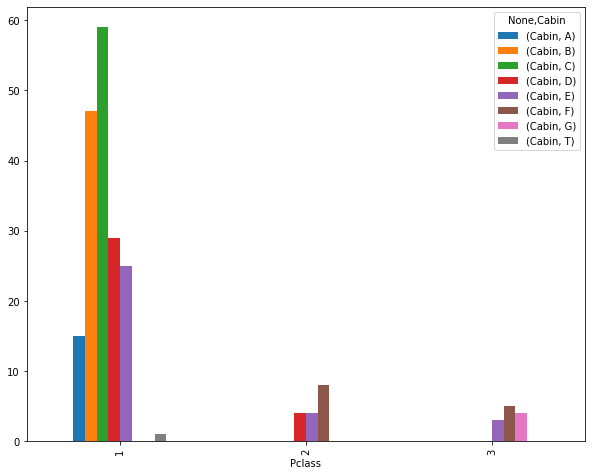

In [69]:
df.groupby(by=['Pclass', 'Cabin']).agg({'Cabin': 'count'}).unstack().plot(kind='bar', figsize=(10,8));

In [70]:
cabin_map = {
    'A': 1
    , 'B': 2
    , 'C': 3
    , 'D': 4
    , 'E': 5
    , 'F': 6
    , 'G': 7
    , 'T': 8
}

#apply the cabin_map to cabin column
df['Cabin'] = df['Cabin'].map(cabin_map)

In [71]:
df['Cabin'].fillna(df.groupby(by=['Pclass'])['Cabin'].transform("mean"), inplace=True) 
df['Cabin'] = np.round(df['Cabin'], decimals=0)

In [72]:
df['Cabin'].value_counts()

6.0    492
5.0    200
3.0     99
2.0     47
4.0     33
1.0     15
7.0      4
8.0      1
Name: Cabin, dtype: int64

In [73]:
df['Cabin'].isnull().sum()

0

In [74]:
df['Embarked'].fillna('S', inplace=True)

In [75]:
df['Embarked'].isnull().sum()

0

In [76]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,891.0,29.112424,13.304424,0.42,21.5000,26.0000,36.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
Cabin,891.0,5.079686,1.342203,1.00,5.0000,6.0000,6.0,8.0000


In [77]:
def bar_charts(df, feature):
    '''
    Inputs:
    df: Dataset
    feature: Name of Feature to Check With Survived
    '''
    _agg = {
        'Name': 'count'
    }
    _groupby = ['Survived', feature]

    df_feature = df.groupby(by=_groupby).agg(_agg)
    
    ax = df_feature.unstack().plot(kind='bar', figsize=(15,6))
    plt.legend(list(df_feature.index.levels[1].unique()))
    plt.xlabel('Survived')
    plt.xticks(np.arange(2), ('No', 'Yes'))
    plt.show();

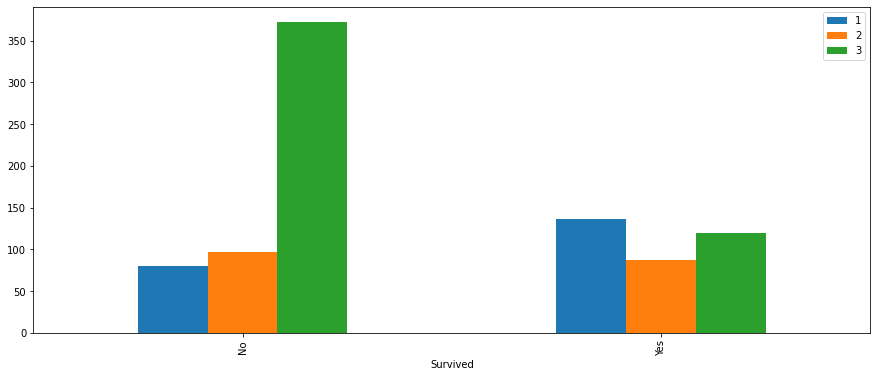

In [78]:
bar_charts(df, 'Pclass')

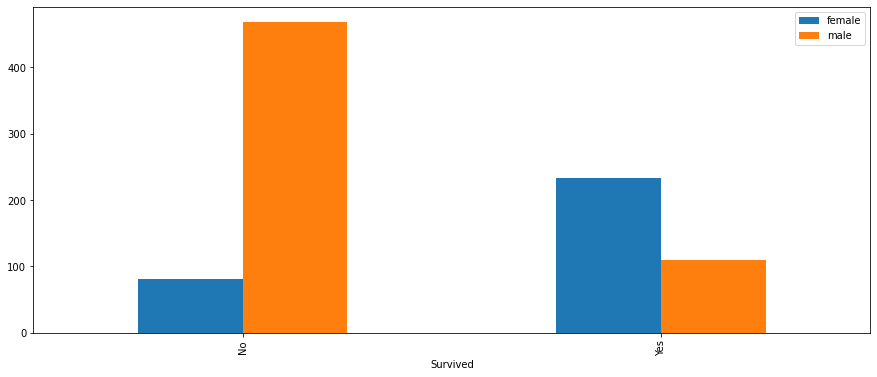

In [79]:
bar_charts(df, 'Sex')

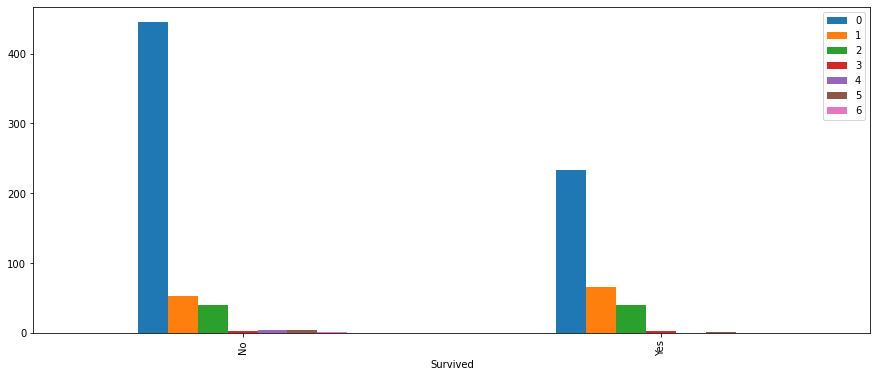

In [80]:
bar_charts(df, 'Parch')

In [81]:
def facetgridplot(train, var):
    facet = sns.FacetGrid(train, hue="Survived", aspect=4)
    facet.map(sns.kdeplot, var, shade= True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend()
    plt.show();

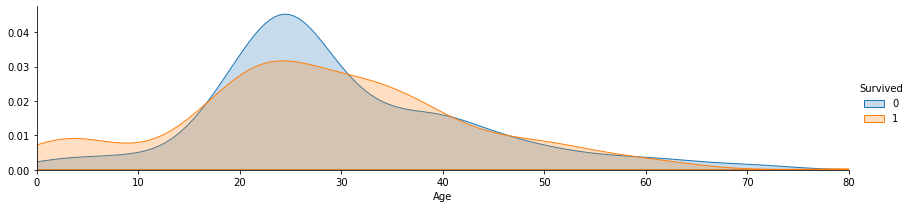

In [82]:
facetgridplot(df, 'Age')

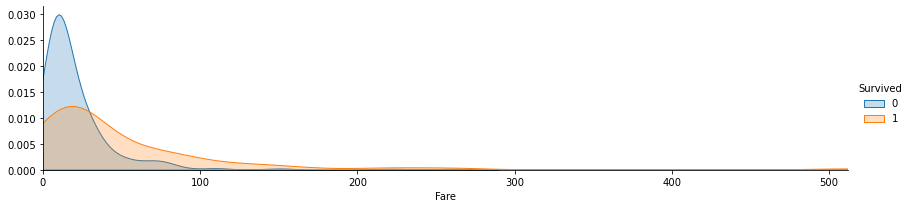

In [83]:
facetgridplot(df, 'Fare')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [84]:
# ANSWER
features = ['Pclass', 'Parch']
X = df[features]
y = df['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [85]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [86]:
# ANSWER
# Create Model
model = LogisticRegression()

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [87]:
# ANSWER
# Fit Model
model.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [88]:
# ANSWER
model.coef_

array([[-0.87239066,  0.337888  ]])

The computed intercept (`intercept_`) is the 1st element of another array:

In [89]:
# ANSWER
model.intercept_

array([1.30430282])

We can create tuples of the predictor names and coefficients like this:

In [90]:
# ANSWER
print(set(zip(features, model.coef_[0])))

{('Parch', 0.3378880048779747), ('Pclass', -0.8723906606017789)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [91]:
for col in zip(X_train.columns, model.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.872391
Parch       +0.337888


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [92]:
# ANSWER
model.score(X_train, y_train)

0.6901197604790419

What is the  `accuracy_score` for the test data?

In [93]:
# ANSWER
model.score(X_test, y_test)

0.6681614349775785

What can we say aout this result?

ANSWER
- ...
- ...

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [94]:
# ANSWER
feature_cols = ['Pclass', 'Parch', 'Age']
X = df[feature_cols]

In [95]:
df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [97]:
# Build Model
log = LogisticRegression()

# Fit Model
log.fit(X_train, y_train)

# Score
log.score(X_train, y_train)


0.7155688622754491

So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- ...
- ...
- ...

Let's see where the model is going wrong by showing the Confusion Matrix:

In [98]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [99]:
# ANSWER
y_pred_class = log.predict(X_test)
print(confusion_matrix(y_test, y_pred_class))

[[105  23]
 [ 50  45]]


Nb. Here is how `confusion_matrix` arranges its output:

In [100]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

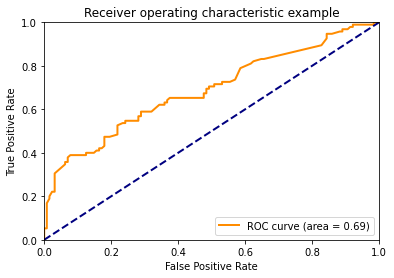

In [101]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = log.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [102]:
titanic_with_dummies = pd.get_dummies(data = df, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,6.0,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,3.0,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,6.0,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,3.0,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,6.0,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [108]:
titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))


PassengerId
1      22.0
2      38.0
3      26.0
4      35.0
5      35.0
       ... 
887    27.0
888    19.0
889    21.5
890    26.0
891    32.0
Name: Age, Length: 891, dtype: float64

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [104]:
# ANSWER
# Set Feature Both Numerical, Categorical
def get_logreg_score(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

    # Build Model
    log = LogisticRegression()

    # Fit
    log.fit(X_train, y_train)

    # Score
    log_score = log.score(X_test, y_test)

    # Return accuracy rate
    return log_score

In [105]:
target_col = 'Survived'
feature_cols = ['Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

0.6636771300448431

In [106]:
# ANSWER
def plot_roc_curve(X_test, y_test):
    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = log.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

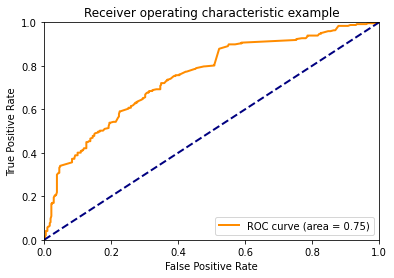

In [54]:
plot_roc_curve(X_train, y_train)

Plot the ROC curve for the new model:

In [44]:
# ANSWER


Can we improve the model by including the remaining features?

In [110]:
# ANSWER
# ANSWER 
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

/Users/hothanhphong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8026905829596412

In [111]:
ttwd = titanic_with_dummies
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                            100 * ttwd[ttwd.Sex_male == 1].Survived.mean(), ttwd.Sex_male.sum(), 
                                            100 * ttwd[ttwd.Sex_female == 1].Survived.mean(), ttwd.Sex_female.sum(),
                                            100 * ttwd[ttwd.Age < 16].Survived.mean(), len(ttwd[ttwd.Age < 16])))

Male survival: 18.89% of 577
Female survival: 74.20% of 314
Child survival: 59.04% of 83


In [112]:
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Build Model
log = LogisticRegression()

# Fit
log.fit(X_train, y_train)

# Make a data frame of results, including actual and predicted response:
y_hat = log.predict(X)
y_hats = pd.Series(y_hat, index = X.index)
y_hatdf = pd.DataFrame({'y_hat': y_hats})
y_actuals = pd.Series(y, index = X.index)    # names 'y', 'y_test' are in use
y_actualdf = pd.DataFrame({'y_actual': y_actuals})   
ttall = y_hatdf.join(y_actualdf).join(X)
ttall.head()

/Users/hothanhphong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,y_hat,y_actual,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,
1,0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
3,1,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
5,0,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [113]:
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                                    100 * ttall[ttall.Sex_male == 1].y_hat.mean(), ttall.Sex_male.sum(), 
                                                    100 * ttall[ttall.Sex_female == 1].y_hat.mean(), ttall.Sex_female.sum(),
                                                    100 * ttall[ttall.Age < 16].y_hat.mean(), len(ttall[ttall.Age < 16])))

Male survival:  4.85% of 577
Female survival: 86.31% of 314
Child survival: 49.40% of 83


## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [114]:
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
log = LogisticRegression()
scores = cross_val_score(log, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()

/Users/hothanhphong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/hothanhphong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

0.7991274872889335

In [115]:
# Build Model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Predict
y_pred_class = logreg.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[114  14]
 [ 30  65]]


/Users/hothanhphong/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [116]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.8026905829596412
0.8026905829596412


In [117]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.19730941704035873
0.19730941704035876


**Sensitivity:** When the actual value is positive, how often is the prediction correct?

Something we want to maximize
How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"
- TP / all positive
    - all positive = TP + FN

In [118]:
sensitivity = TP / float(FN + TP)
print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.6842105263157895
0.6842105263157895


**Specificity:** When the actual value is negative, how often is the prediction correct?

Something we want to maximize
How "specific" (or "selective") is the classifier in predicting positive instances?
TN / all negative
all negative = TN + FP

In [119]:
specificity = TN / (TN + FP)

print(specificity)

0.890625


In [120]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.109375
0.109375


**Precision:** When a positive value is predicted, how often is the prediction correct?

How "precise" is the classifier when predicting positive instances?

In [121]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.8227848101265823
0.8227848101265823




---



---



> > > > > > > > > © 2021 Institute of Data


---



---



